In [1]:
import pickle
import gc
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from random import sample
from math import ceil

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors, load_facebook_model

DB_PATH = 'data/db/spotify.db'
SEED = 413

# Similarity Similarity Ensemble

This notebook uses the Semantic Similarity scores generated by several models (BERT, FastText, USE, Word2Vec, and GLoVe) and evaluates which scores are the most relevant for this use case (cleaning search results of user-generated content, playlists).

To do this, I manually labeled a small sample (not a completely random sample as most of the search results are good so there isn't much balance to the data) and used a Random Forest and Linear Regression to assess feature importance and coefficients to see which models were the most accurate.

In the end, I use the RF similarity scores to clean / filter my data.

In [2]:
''' I originally had labeled data with different special charcter rules, so
first I need to merge it back together. There were about 1.2k labels in the original dataset.'''

df = pd.read_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT')
labels = pd.read_csv('existing_labels_before_new_spec_char_rules.csv', encoding='iso-8859-1')
labels['lookup'] = labels['query'].astype(str) + '_____' + labels['search_rank'].astype(str)
df['lookup'] = df['query'].astype(str) + '_____' + df['search_rank'].astype(str)
df = deepcopy(df.merge(labels[['lookup', 'SCORE']], on = 'lookup', how = 'left'))
df.drop('lookup', axis = 1, inplace = True)
del labels
df.reset_index(drop = True).to_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT_&_init-score')

### Label Some More

Although I'm sure that the previous labels would still be valid with the new special character rules, I'd still like to make sure. So I'm adding about 500 more labels (~50% more).

In [3]:
df = pd.read_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT_&_init-score')

# remove data we already have labels for
df = deepcopy(df[df.SCORE.isnull()].reset_index(drop = True))
df.drop('SCORE', 1, inplace = True)

# get standardized similarity scores
scaler = StandardScaler()
stzd_X = scaler.fit_transform(df.iloc[:,4:-1])

# add standardized similarity to main df
sdf = pd.DataFrame(stzd_X, columns = df.columns[4:-1].tolist())
df[sdf.columns.tolist()] = deepcopy(sdf)

# add an avg of all overall similarity scores for each model
df['avg_all'] = df[[
    'bert_overall_similarity',
    'use_transformer_overall_similarity',
    'use_dan_overall_similarity',
    'glove_overall_similarity',
    'ft_wiki_overall_similarity',
    'ft_crawl_overall_similarity']].mean(1)

# export sample to label
tdf = deepcopy(df[['query', 'track_id', 'playlist_name', 'search_rank', 'avg_all']])
tdf[tdf.avg_all < 0].sample(50000).to_csv('new_plns_to_label_new_spec_char.csv')

### Merge Old & New Labels

In [4]:
# load new labels and join with data
labels = pd.read_csv('addl_labels_after_spec_char_update.csv', encoding='iso-8859-1')
labels.index = labels['index']
labels.drop('index', axis = 1, inplace = True)
joined = df.join(labels[['SCORE', 'playlist_name']], rsuffix = '_TEMP').dropna()
joined = deepcopy(joined[['query', 'track_id', 'playlist_name', 'search_rank', 'SCORE']])

# append old labels
old_labels = pd.read_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT_&_init-score').dropna()
joined = deepcopy(joined.append(old_labels[['query', 'track_id', 'playlist_name', 'search_rank', 'SCORE']]))

''' join with existing labels from previous dataset'''
labels = deepcopy(joined)
df = pd.read_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT')
labels['lookup'] = labels['query'].astype(str) + '_____' + labels['search_rank'].astype(str)
df['lookup'] = df['query'].astype(str) + '_____' + df['search_rank'].astype(str)
df = deepcopy(df.merge(labels[['lookup', 'SCORE']], on = 'lookup', how = 'left'))
df.drop('lookup', axis = 1, inplace = True)
del labels
df.reset_index(drop = True).to_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT_&_init&new-score')

## Standardize Full Dataset

In [8]:
df = pd.read_feather('final_uniq_plns_WITH_BERT&USE&W2V&GLOVE&FT_&_init&new-score')

# get standardized similarity scores
scaler = StandardScaler()
stzd_X = scaler.fit_transform(df.iloc[:,4:-1])

# add standardized similarity to main df
sdf = pd.DataFrame(stzd_X, columns = df.columns[4:-1].tolist())
df[sdf.columns.tolist()] = deepcopy(sdf)

# add an avg of all overall similarity scores for each model
df['avg_all'] = df[[
    'bert_overall_similarity',
    'use_transformer_overall_similarity',
    'use_dan_overall_similarity',
    'glove_overall_similarity',
    'ft_wiki_overall_similarity',
    'ft_crawl_overall_similarity']].mean(1)

# export
df.rename(columns = {'SCORE': 'score'}, inplace = True)
df.reset_index(drop = True).to_feather('final_full_standardized_uniq_plns_with_labels')

## Build Model

In [18]:
# load data WITH LABELS ONLY
df = pd.read_feather('final_full_standardized_uniq_plns_with_labels').dropna()

In [19]:
df.sample()

,query,track_id,playlist_name,search_rank,bert_max_pln_similarity,bert_avg_pln_similarity,bert_max_token_max_similarity,bert_avg_token_max_similarity,bert_overall_avg_max_similarity,bert_overall_avg_avg_similarity,...,ft_wiki_overall_similarity,ft_crawl_max_pln_similarity,ft_crawl_avg_pln_similarity,ft_crawl_max_token_max_similarity,ft_crawl_avg_token_max_similarity,ft_crawl_overall_avg_max_similarity,ft_crawl_overall_avg_avg_similarity,ft_crawl_overall_similarity,score,avg_all
1030145,running,1MB60Ingbxmdukc2wq8b2G,remix hits,464,-1.954781,-1.765774,-3.86681,-3.552363,-3.136856,-2.890563,...,-2.742427,-0.902903,-0.834854,-2.368756,-2.314524,-1.824455,-1.790294,-1.818691,0.0,-2.62401


In [22]:
df.score.value_counts()

1.0    758
0.0    758
0.5    143
Name: score, dtype: int64

In [20]:
df.drop(['query', 'track_id', 'playlist_name', 'search_rank'], axis = 1, inplace = True)
df = df[[col for col in df.columns if col != 'score'] + ['score']]

In [21]:
df.head(3)

,bert_max_pln_similarity,bert_avg_pln_similarity,bert_max_token_max_similarity,bert_avg_token_max_similarity,bert_overall_avg_max_similarity,bert_overall_avg_avg_similarity,bert_overall_similarity,use_transformer_max_pln_similarity,use_transformer_avg_pln_similarity,use_transformer_max_token_max_similarity,...,ft_wiki_overall_similarity,ft_crawl_max_pln_similarity,ft_crawl_avg_pln_similarity,ft_crawl_max_token_max_similarity,ft_crawl_avg_token_max_similarity,ft_crawl_overall_avg_max_similarity,ft_crawl_overall_avg_avg_similarity,ft_crawl_overall_similarity,avg_all,score
245,-1.019679,-0.856142,-3.372802,-3.094917,-2.213858,-2.006395,-2.135536,-1.813332,-1.725463,-3.611603,...,-1.657022,-0.882583,-0.813542,-2.614015,-2.555157,-1.931932,-1.900680,-1.928271,-2.272804,0.0
249,-0.397358,-0.250772,-1.150517,-1.037107,-0.792924,-0.645239,-0.726902,-1.040763,-0.938433,-2.317882,...,-2.237054,-1.055477,-0.994882,-2.684592,-2.624402,-2.090746,-2.063793,-2.090193,-1.843457,0.0
251,-2.362173,-2.162070,-5.422951,-4.993332,-4.110228,-3.822986,-4.015490,-1.640258,-1.549150,-3.585043,...,-3.336442,-1.816045,-1.792604,-4.015129,-3.929839,-3.296856,-3.302553,-3.319907,-3.309651,0.0


## Test Model

In [ ]:
n_train = int(len(df) * 0.8)

In [146]:
results = {'rf': [], 'lr': []}

for _ in range(500):
    
    if _%10==0: print(f'Iter: {_}')
    
    # shuffle data
    df = deepcopy(df.sample(len(df)).reset_index(drop = True))
    
    # set train/test
    X_train = df.iloc[:n_train,:-1].values
    y_train = df.iloc[:n_train,-1].values
    X_test = df.iloc[n_train:,:-1].values
    y_test = df.iloc[n_train:,-1].values
    
    # init
    #rf = RandomForestRegressor(random_state = SEED, n_estimators = 1000)
    
    # FIRST GRID SEARCH
    rf = RandomForestRegressor(
        bootstrap = True,
        max_depth = 24,
        max_features = 'sqrt',
        max_leaf_nodes = None,
        min_impurity_decrease = 0.0,
        min_impurity_split = None,
        min_samples_leaf = 3,
        min_samples_split = 2,
        min_weight_fraction_leaf = 0.0,
        n_estimators = 290,
        #random_state = SEED,
    )
    
#     # SECOND GRID SEARCH
#     rf = RandomForestRegressor(
#         bootstrap = True,
#         criterion = 'mse',
#         max_depth = 22,
#         max_features = 'sqrt',
#         max_leaf_nodes = None,
#         min_impurity_decrease = 0.0,
#         min_impurity_split = None,
#         min_samples_leaf = 3,
#         min_samples_split = 2,
#         min_weight_fraction_leaf = 0.0,
#         n_estimators = 295,
#         #random_state = SEED,
#     )
    
    lr = LinearRegression()
    
    # fit
    rf.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    
    # save results
    results['rf'].append(float(mse(y_true = y_test, y_pred = rf.predict(X_test)) ** 0.5))
    results['lr'].append(float(mse(y_true = y_test, y_pred = lr.predict(X_test)) ** 0.5))
    
    del X_train, y_train, X_test, y_test, rf, lr
    gc.collect()
    
    print('done.')
    
# build df
results = pd.DataFrame({'rf': results['rf'], 'lr': results['lr']})

In [72]:
# FIRST GRID SEARCH
results.rf.describe()

count    500.000000
mean       0.293502
std        0.013731
min        0.253555
25%        0.284499
50%        0.293820
75%        0.302505
max        0.333928
Name: rf, dtype: float64

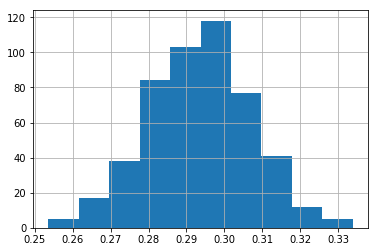

In [71]:
results.rf.hist()

In [74]:
# SECOND GRID SEARCH
results.rf.describe()

count    500.000000
mean       0.294388
std        0.014050
min        0.254138
25%        0.285190
50%        0.294705
75%        0.303582
max        0.330818
Name: rf, dtype: float64

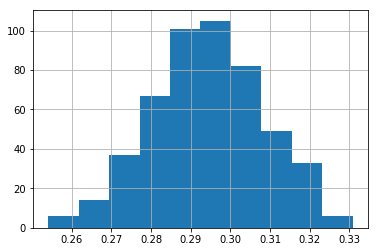

In [75]:
results.rf.hist()

In [117]:
results.lr.describe()

count    500.000000
mean       0.319360
std        0.012050
min        0.282213
25%        0.311495
50%        0.319391
75%        0.327726
max        0.356968
Name: lr, dtype: float64

# Random Forest Hyperparamater Tuning

## Random Search

In [28]:
# shuffle data
df = deepcopy(df.sample(len(df)).reset_index(drop = True))

# set train/test
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [29]:
n_estimators = [50, 100, 200, 300, 400, 500, 600, 700,
                800, 900, 1000, 1500, 2000, 3000]                 # Number of trees in random forest
max_features = ['auto', 'sqrt']                                   # Number of features to consider at every split
max_depth = [None, 5, 10, 15, 20, 30, 40, 50, 60, 80, 100, 120]   # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 15, 20, 25]                        # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]        # Minimum number of samples required at each leaf node
bootstrap = [True, False]                                         # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
rf      = RandomForestRegressor()
rf_rand = RandomizedSearchCV(estimator = rf,
                             param_distributions = random_grid,
                             n_iter = 2500,
                             cv = 5,
                             verbose = 2,
                             random_state = SEED,
                             n_jobs = -1
                            )

In [33]:
rf_rand.fit(X, y)

In [32]:
rf_rand.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Initial Grid Search

In [44]:
# shuffle data
df = deepcopy(df.sample(len(df)).reset_index(drop = True))

# set train/test
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [48]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt'],
    'max_depth': [16, 18, 20, 22, 24], # 20
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], # 5
    'min_samples_split': [2, 3, 4], # 2
    'n_estimators': [260, 270, 280, 290, 300, 310, 320, 330, 340], # 300
}
# init model
rf = RandomForestRegressor()

# init grid search
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 10,
    n_jobs = -1,
    verbose = 2,
)

In [51]:
grid_search.fit(X, y)

In [50]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Final Grid Search

In [59]:
# shuffle data
df = deepcopy(df.sample(len(df)).reset_index(drop = True))

# set train/test
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [60]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt'],
    'max_depth': [22, 23, 24, 25, 26], # 24
    'min_samples_leaf': [2, 3, 4], # 3
    'min_samples_split': [2], # 2
    'n_estimators': [280, 285, 290, 295, 300], # 290
}
# init model
rf = RandomForestRegressor()

# init grid search
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 10,
    n_jobs = -1,
    verbose = 2,
)

In [110]:
grid_search.fit(X, y)

In [62]:
grid_search.best_estimator_ss

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=22,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=295, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Get Feature Importance & Coefficients

In [109]:
imp = []

for _ in range(250):
    
    print(_)
    
    # shuffle data
    df = deepcopy(df.sample(len(df)).reset_index(drop = True))
    
    # set X and y
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    # the crawl embeddings tend to score higher in general
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_X = scaler.fit_transform(X)
    
    # init & fit
    rf = RandomForestRegressor(
        bootstrap = True,
        max_depth = 24,
        max_features = 'sqrt',
        max_leaf_nodes = None,
        min_impurity_decrease = 0.0,
        min_impurity_split = None,
        min_samples_leaf = 3,
        min_samples_split = 2,
        min_weight_fraction_leaf = 0.0,
        n_estimators = 290,
        random_state = SEED,
    )
    rf.fit(scaled_X, y)
    
    # save
    imp.append(deepcopy(rf.feature_importances_))

In [91]:
importances = pd.DataFrame(imp, columns = df.columns[:-1].tolist())

In [92]:
importances.mean().sort_values(ascending = False)

ft_wiki_overall_avg_avg_similarity            0.091070
ft_wiki_overall_similarity                    0.088761
avg_all                                       0.077965
ft_wiki_avg_token_max_similarity              0.072831
ft_wiki_max_token_max_similarity              0.064898
ft_wiki_overall_avg_max_similarity            0.064355
use_overall_similarity                        0.038384
use_dan_overall_avg_avg_similarity            0.033374
use_transformer_overall_avg_max_similarity    0.030428
use_transformer_overall_avg_avg_similarity    0.028534
use_transformer_overall_similarity            0.026824
ft_crawl_overall_similarity                   0.026218
use_dan_overall_similarity                    0.024760
use_dan_overall_avg_max_similarity            0.022077
ft_crawl_overall_avg_max_similarity           0.020009
ft_crawl_overall_avg_avg_similarity           0.019369
ft_crawl_max_token_max_similarity             0.017591
ft_crawl_avg_token_max_similarity             0.016278
glove_max_

In [147]:
coef = []

for _ in range(250):
    
    print(_)
    
    # shuffle data
    df = deepcopy(df.sample(len(df)).reset_index(drop = True))
    
    # set X and y
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values

    # the crawl embeddings tend to score higher in general
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_X = scaler.fit_transform(X)
    
    # fit model
    lr = LinearRegression()
    lr.fit(scaled_X, y);
    
    # save
    coef.append(deepcopy(lr.coef_))

In [115]:
coefs = pd.DataFrame(coef, columns = df.columns[:-1].tolist())
coefs.mean().sort_values(ascending = False) / 1e10

bert_overall_avg_max_similarity               117.356511
bert_overall_similarity                        45.243495
avg_all                                        15.504321
use_transformer_avg_pln_similarity              5.726846
use_transformer_avg_token_max_similarity        5.089262
ft_wiki_overall_similarity                      4.546034
use_transformer_max_pln_similarity              4.071484
ft_wiki_avg_token_max_similarity                3.690495
ft_wiki_avg_pln_similarity                      3.690495
use_transformer_max_token_max_similarity        3.618196
use_dan_max_pln_similarity                      2.336751
use_dan_max_token_max_similarity                2.336751
glove_overall_avg_max_similarity                2.223537
use_dan_overall_avg_avg_similarity              1.897487
ft_crawl_overall_similarity                     1.412537
ft_crawl_max_pln_similarity                     1.211309
ft_crawl_max_token_max_similarity               1.177286
use_dan_avg_pln_similarity     

# Use RF Model to Predict on Full Dataset

In [3]:
# load data
all_plns = deepcopy(pd.read_feather('final_full_standardized_uniq_plns_with_labels'
                                   ).drop(['track_id', 'score'], axis = 1))

# load labeled data
df = pd.read_feather('final_full_standardized_uniq_plns_with_labels').dropna()
df.drop(['query', 'track_id', 'playlist_name', 'search_rank'], axis = 1, inplace = True)
df = df[[col for col in df.columns if col != 'score'] + ['score']]

In [48]:
preds = []

test_X = all_plns.iloc[:,3:].values

for i in range(250):
    
    print(f'Iter: {i}')
    
    # shuffle data
    df = deepcopy(df.sample(len(df)).reset_index(drop = True))
    
    # set X and y
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values
    
    # Best RF Model
    rf = RandomForestRegressor(
        bootstrap = True,
        max_depth = 24,
        max_features = 'sqrt',
        max_leaf_nodes = None,
        min_impurity_decrease = 0.0,
        min_impurity_split = None,
        min_samples_leaf = 3,
        min_samples_split = 2,
        min_weight_fraction_leaf = 0.0,
        n_estimators = 290,
    )
    rf.fit(X, y)
    
    # save
    preds.append(deepcopy(rf.predict(test_X)))

In [6]:
# add to pln data
df = pd.DataFrame(np.array(preds).T)
avg_preds = df.mean(1)
all_plns['rf_similarity'] = avg_preds.values

In [ ]:
all_plns.reset_index(drop = True).to_feather('FINAL_uniq_plns_with_rf_similarity')

# Analyze

In [34]:
all_plns[all_plns.rf_similarity < (all_plns.rf_similarity.mean() - (all_plns.rf_similarity.std() * 1))][
    ['query', 'playlist_name', 'search_rank', 'rf_similarity']
].sample(20).sort_values('rf_similarity', ascending = False)

,query,playlist_name,search_rank,rf_similarity
884012,breakfast,mac tonight,101,0.714643
767503,korea OR korean OR south korea OR 대한민국 OR 한국어,south szn,6015,0.653743
1362582,indian classical OR classical indian,feathered indians,6736,0.565209
528129,sexual,tumblr deleted porn,1614,0.530899
986325,happiness,ti ho portato un pacco happy birthday,573,0.527008
1028271,rhythm,lactic acid run 175 bpm,19,0.472443
873530,all time,beat house,852,0.466805
451982,going out,it s gonna be a good one,1457,0.464573
1072388,90s OR nineties,soir e ann e 90 2000,3889,0.426075
479552,out of this world,teatro essential playlist,488,0.392410


In [43]:
all_plns[(all_plns.rf_similarity < 0.65) & (all_plns.rf_similarity > 0.60)][
    ['query', 'playlist_name', 'search_rank', 'rf_similarity']
].sample(20).sort_values('rf_similarity', ascending = False)

,query,playlist_name,search_rank,rf_similarity
1028256,rhythm,sexy as folk,4,0.649524
291365,earthy,petrichor,96,0.649023
1072531,90s OR nineties,punk 90 s,4036,0.641092
1053924,00s OR 2000s,smash hits 2000 present,1728,0.640569
781144,south america OR sudamerica,anywhere south of 49th st,927,0.640217
273900,progressive house,electric sheep,1031,0.634916
1063572,70s OR seventies,anni 60 70 italiani compilation roberto,1711,0.633367
1262849,oriental,se oriente,1466,0.632096
972617,feeling blue OR feeling sad OR feeling bad OR ...,lonny s rainy day,445,0.630560
435417,clubbing,50cent 50 cent in the club dirty in da club,407,0.625797


In [47]:
len(all_plns[all_plns.rf_similarity < 0.65]) / len(all_plns)

0.08513400075171937

# Conclusion

After some brief analysis, it seems that 0.65 would be a good similarity score threshold. I still keep ~91% of data and if I want to do aditional, more strict filtering, I can do it after all of the other cleaning steps have been processed.